In [ ]:
!kaggle datasets download -d nelgiriyewithana/emotions

Dataset URL: https://www.kaggle.com/datasets/nelgiriyewithana/emotions
License(s): other
 89% 14.0M/15.7M [00:01<00:00, 13.8MB/s]
100% 15.7M/15.7M [00:01<00:00, 8.88MB/s]


In [ ]:
!unzip emotions.zip -d /content/emotions

Archive:  emotions.zip
  inflating: /content/emotions/text.csv  


# Importing

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("/content/emotions/text.csv")
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [ ]:
df.drop(columns="Unnamed: 0", inplace=True)
df.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [ ]:
emotion_map = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}
df["label"] = df["label"].map(emotion_map)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  object
dtypes: object(2)
memory usage: 6.4+ MB


# Pre Processing

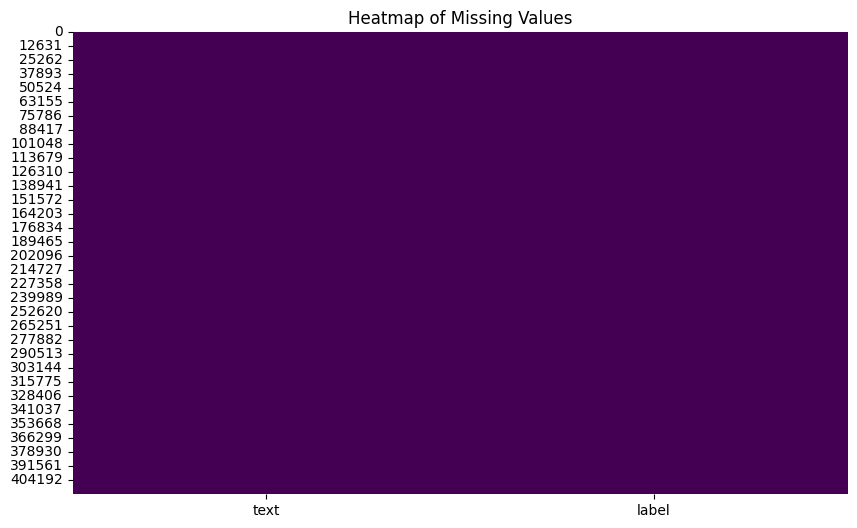

In [ ]:
# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create a heatmap to visualize missing values
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')

# Display the plot
plt.title('Heatmap of Missing Values')
plt.show()

In [ ]:
# Identify duplicate rows
duplicate_rows = df.duplicated()

# Count the number of duplicate rows
num_duplicates = duplicate_rows.sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 686


In [ ]:
# Remove exact duplicates, keeping the first occurrence
df = df.drop_duplicates()
print(f"DataFrame shape after removing exact duplicates: {df.shape}")

DataFrame shape after removing exact duplicates: (416123, 2)


In [ ]:
# Calculate the length of each text entry
df['text_length'] = df['text'].apply(len)

# Display basic statistics
print(df['text_length'].describe())

count    416123.000000
mean         97.102662
std          56.176302
min           2.000000
25%          54.000000
50%          86.000000
75%         128.000000
max         830.000000
Name: text_length, dtype: float64


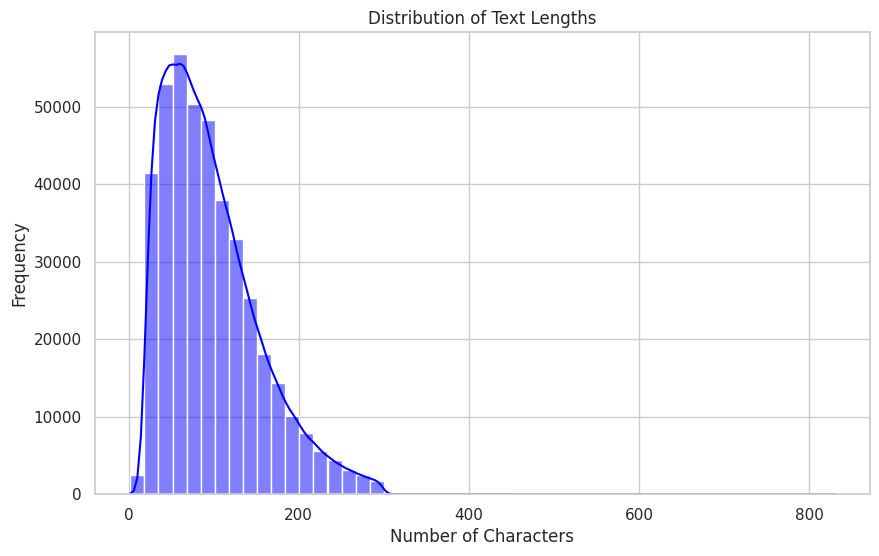

In [ ]:
# Set plot style
sns.set(style="whitegrid")

# Plot distribution of text lengths
plt.figure(figsize=(10,6))
sns.histplot(df['text_length'], bins=50, kde=True, color='blue')
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

Number of text length outliers: 9952


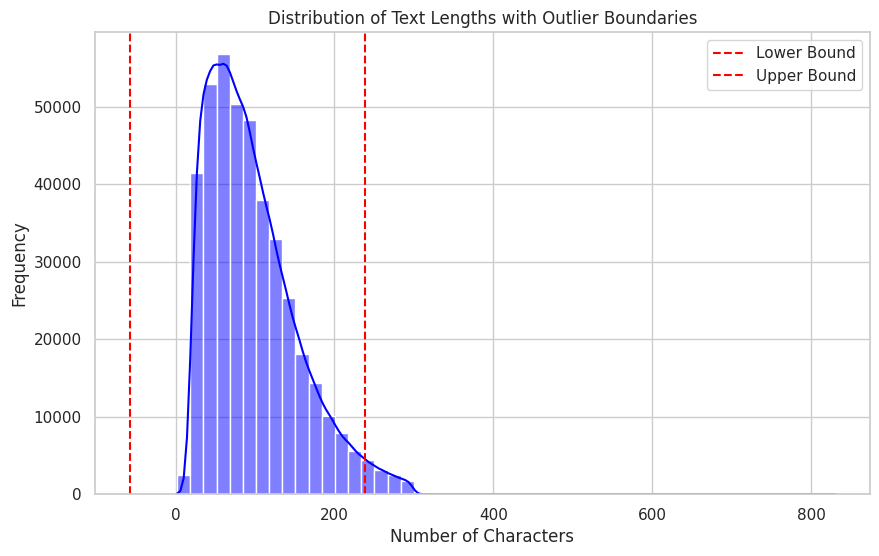

In [ ]:
# Calculate Q1 and Q3
Q1 = df['text_length'].quantile(0.25)
Q3 = df['text_length'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers_length = df[(df['text_length'] < lower_bound) | (df['text_length'] > upper_bound)]
print(f"Number of text length outliers: {outliers_length.shape[0]}")

plt.figure(figsize=(10,6))
sns.histplot(df['text_length'], bins=50, kde=True, color='blue')
plt.axvline(lower_bound, color='red', linestyle='--', label='Lower Bound')
plt.axvline(upper_bound, color='red', linestyle='--', label='Upper Bound')
plt.title('Distribution of Text Lengths with Outlier Boundaries')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
def feature_outlier_analysis(df, feature, start=None, end=None, mode=0, save_filename=None):
    """
    Analyze and identify outliers based on a numerical feature.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - feature (str): The numerical feature to analyze.
    - start (int, optional): The starting value of the feature to consider. Defaults to the minimum value.
    - end (int, optional): The ending value of the feature to consider. Defaults to the maximum value.
    - mode (int, optional): If not zero, saves the subset to CSV. Defaults to 0.
    - save_filename (str, optional): The filename to save the subset if mode != 0.

    Returns:
    - None
    """
    # Ensure the feature exists in the DataFrame
    if feature not in df.columns:
        print(f"Feature '{feature}' not found in the DataFrame.")
        return

    # Set default start and end if not provided
    if start is None:
        start = int(df[feature].min())
    if end is None:
        end = int(df[feature].max())

    print(f"Analyzing feature '{feature}' from {start} to {end}.")

    # Iterate over the specified range
    for i in range(start, end + 1):
        subset = df[df[feature] == i]
        count = len(subset)
        print(f"Feature '{feature}' = {i}: {count} entries.")

        # Save to CSV if mode is not zero
        if mode != 0 and save_filename:
            subset.to_csv(save_filename, mode='a', index=False)  # Append to the file

    print("Feature outlier analysis completed.")

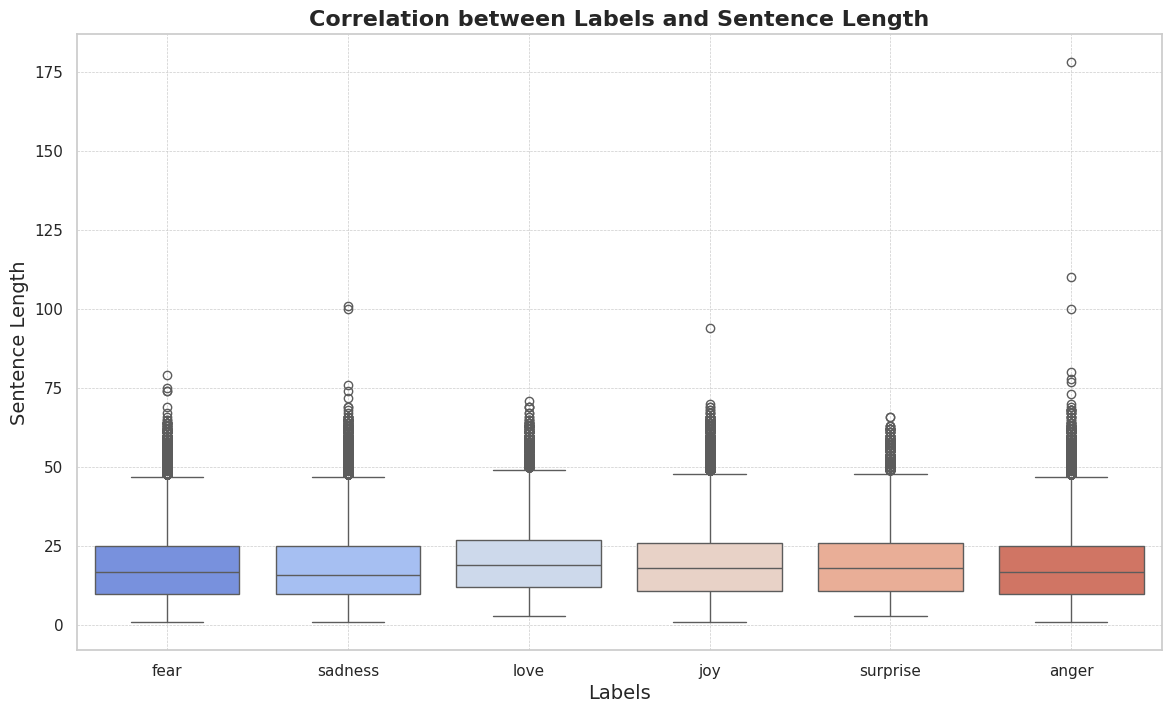

In [ ]:
# Calculate sentence length using vectorized string operations
df['sentence_length'] = df['text'].str.split().str.len()

plt.figure(figsize=(14, 8))
sns.boxplot(x='label', y='sentence_length', data=df, palette="coolwarm")
plt.title('Correlation between Labels and Sentence Length', fontsize=16, fontweight='bold')
plt.xlabel("Labels", fontsize=14)
plt.ylabel("Sentence Length", fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
def sentence_length_outlier(start=1, end=2, save_csv=False):
    """
    Identifies and optionally saves DataFrame rows with sentence lengths within a specified range.

    Parameters:
    - start (int): Starting sentence length (inclusive).
    - end (int): Ending sentence length (exclusive).
    - save_csv (bool): If True, saves each group to a separate CSV file.

    Returns:
    - outliers (dict): A dictionary with sentence lengths as keys and corresponding DataFrames as values.
    """
    outliers = {}
    for length in range(start, end):
        filtered_df = df[df['sentence_length'] == length]
        count = len(filtered_df)

        print(f"Sentence length {length} has {count} occurrences.")

        if count > 0:
            outliers[length] = filtered_df
            if save_csv:
                filename = f"df_sentence_length_{length}.csv"
                filtered_df.to_csv(filename, index=False)
                print(f"Saved {count} records to {filename}")

    return outliers

# Example usage:
outlier_data = sentence_length_outlier(start=1, end=5, save_csv=True)

Sentence length 1 has 25 occurrences.
Saved 25 records to df_sentence_length_1.csv
Sentence length 2 has 76 occurrences.
Saved 76 records to df_sentence_length_2.csv
Sentence length 3 has 957 occurrences.
Saved 957 records to df_sentence_length_3.csv
Sentence length 4 has 7539 occurrences.
Saved 7539 records to df_sentence_length_4.csv


In [ ]:
# Define the sentence lengths to remove
lengths_to_remove = [1, 2, 3]

# Filter the DataFrame to exclude these lengths
df= df[~df['sentence_length'].isin(lengths_to_remove)].copy()

# Optionally, reset the index for cleanliness
df.reset_index(drop=True, inplace=True)

# Optional: Save the filtered DataFrame for future use
df.to_csv("df_filtered_sentence_length.csv", index=False)
print(f"Filtered DataFrame saved with {len(df)} records.")

Filtered DataFrame saved with 415065 records.


In [ ]:
df.shape

(415065, 4)

In [ ]:
# Get the 10 longest sentences and their indices
top_sentences = df.sort_values(by='sentence_length', ascending=False).head(20)
top_indices = top_sentences.index

# Display the top sentences
print("Top 20 Longest Sentences:")
print(top_sentences[['text', 'sentence_length']])

Top 20 Longest Sentences:
                                                     text  sentence_length
347001  a few days back i was waiting for the bus at t...              178
290349  two years back someone invited me to be the tu...              110
97687   i have been thinking of changing my major for ...              101
38584   when i got into a bus i found that my wallet h...              100
22750   my living and working conditions at home were ...              100
332276  i had a dream i had a very close friend who ha...               94
249491  i worked with several classmates on a project ...               80
158527  i was camping in an old broken hut which had n...               79
56688   last semester when i dated a girl whom ive kno...               78
162121  i was a prefect at secondary school on the spo...               77
174240  when i was in lower six class during the summe...               76
387931  a boy phoned me at night and wanted to talk to...               75

In [ ]:
df = df.drop(index=[348392, 291479, 97990, 38708, 22827, 333596])

In [ ]:
df.shape

(415059, 4)

## Data Cleaning

In [ ]:
import re
import string
import unicodedata

# Pre-compile regex patterns for efficiency
HTML_TAG_RE = re.compile(r'<.*?>', re.DOTALL)
URL_RE = re.compile(r'https?://\S+|www\.\S+')
NUMERIC_RE = re.compile(r'\d+')
NON_ALPHANUMERIC_RE = re.compile(r'[^a-zA-Z\s]')
EXTRA_WHITESPACE_RE = re.compile(r'\s+')
EMOJI_RE = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # Emoticons
    "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
    "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
    "\U0001F1E0-\U0001F1FF"  # Flags
    "]+",
    flags=re.UNICODE
)

def processing_data(text):
    """
    Preprocesses the input text by performing the following operations:
    1. Removes HTML tags.
    2. Removes URLs.
    3. Removes emojis and non-standard Unicode characters.
    4. Removes numeric values.
    5. Removes non-alphanumeric characters (excluding spaces).
    6. Converts text to lowercase.
    7. Removes extra whitespaces.
    8. Strips leading and trailing whitespaces.

    Parameters:
    - text (str): The input text to preprocess.

    Returns:
    - str: The cleaned and preprocessed text.
    """
    if pd.isnull(text) or not isinstance(text, str):
        return ""

    # Normalize unicode characters
    text = unicodedata.normalize('NFKD', text)

    # Remove HTML tags
    text = HTML_TAG_RE.sub('', text)

    # Remove URLs
    text = URL_RE.sub('', text)

    # Remove emojis
    text = EMOJI_RE.sub('', text)

    # Remove numeric values
    text = NUMERIC_RE.sub('', text)

    # Remove non-alphanumeric characters (excluding spaces)
    text = NON_ALPHANUMERIC_RE.sub('', text)

    # Convert to lowercase
    text = text.lower()

    # Remove extra whitespaces
    text = EXTRA_WHITESPACE_RE.sub(' ', text)

    # Strip leading and trailing whitespaces
    text = text.strip()

    return text

In [ ]:
df['text'] = df['text'].apply(processing_data)

In [ ]:
df.head(20)

,text,label,text_length,sentence_length
0,i just feel really helpless and heavy hearted,fear,45,8
1,ive enjoyed being able to slouch about relax a...,sadness,234,45
2,i gave up my internship with the dmrg and am f...,fear,63,12
3,i dont know i feel so lost,sadness,26,7
4,i am a kindergarten teacher and i am thoroughl...,fear,222,42
5,i was beginning to feel quite disheartened,sadness,42,7
6,i would think that whomever would be lucky eno...,love,125,25
7,i fear that they won t ever feel that deliciou...,joy,124,25
8,im forever taking some time out to have a lie ...,surprise,71,15
9,i can still lose the weight without feeling de...,sadness,52,9


In [ ]:
# Calculate the counts of each emotion
label_counts = df['label'].value_counts()
label_percentages = df['label'].value_counts(normalize=True) * 100

# Create a DataFrame for better readability
label_distribution = pd.DataFrame({
    'Count': label_counts,
    'Percentage': label_percentages.round(2)
})

print(label_distribution)

           Count  Percentage
label                       
joy       140474       33.84
sadness   120692       29.08
anger      57008       13.73
fear       47510       11.45
love       34441        8.30
surprise   14934        3.60


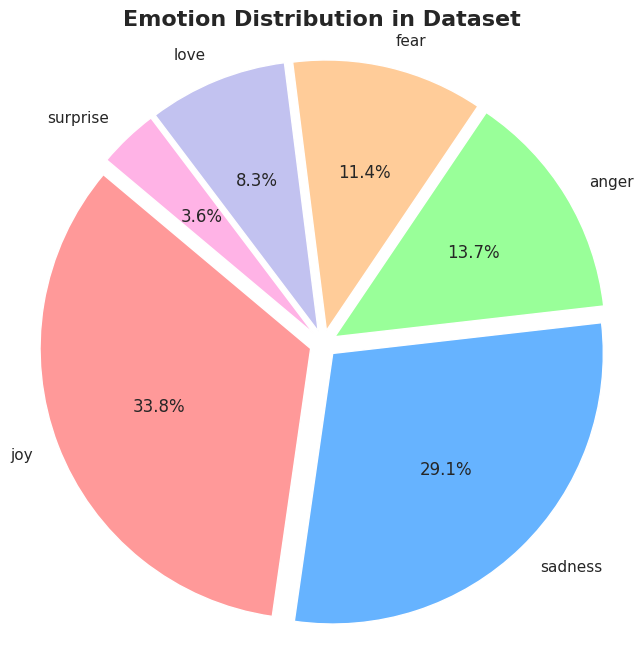

In [ ]:
# Define colors for each emotion
colors = ['#FF9999','#66B3FF','#99FF99','#FFCC99','#C2C2F0','#FFB3E6']

plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=colors, explode=(0.05, 0.05, 0.05, 0.05, 0.05, 0.05))
plt.title('Emotion Distribution in Dataset', fontsize=16, fontweight='bold')
plt.axis('equal')  # Ensures that pie is drawn as a circle.
plt.show()

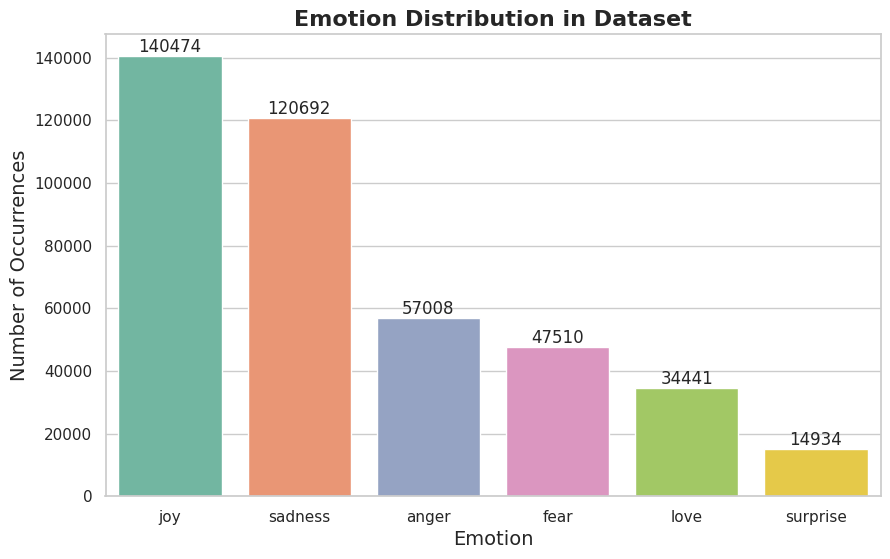

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df, palette="Set2", order=label_counts.index)
plt.title('Emotion Distribution in Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Emotion', fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=14)

# Adding the count labels on top of each bar
for index, value in enumerate(label_counts):
    plt.text(index, value + 50, str(value), ha='center', va='bottom', fontsize=12)

plt.show()

## Preprocessing Lemmatization and Filtering StopWords

In [ ]:
import time
import re
import spacy
from tqdm import tqdm
import pandas as pd

# Load SpaCy model with parser and NER disabled for efficiency
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Set maximum text length if needed (adjust as per your dataset)
nlp.max_length = 1_500_000

def process_text(doc):
    """
    Processes a SpaCy Doc object by lemmatizing tokens, removing stopwords, and filtering non-alphabetic tokens.

    Parameters:
    - doc (spacy.tokens.Doc): The SpaCy Doc object to process.

    Returns:
    - str: The processed text.
    """
    return ' '.join(
        token.lemma_ for token in doc
        if not token.is_stop and token.is_alpha
    )

def process_texts_sequentially(texts, batch_size=500):
    """
    Processes a list of texts sequentially using SpaCy's nlp.pipe with a progress bar.

    Parameters:
    - texts (list of str): The list of text strings to process.
    - batch_size (int): The number of texts to process in each batch.

    Returns:
    - list of str: The list of processed text strings.
    """
    processed_texts = []

    # Initialize tqdm progress bar
    for doc in tqdm(nlp.pipe(texts, batch_size=batch_size, disable=["parser", "ner"]), total=len(texts), desc="Processing Texts"):
        processed_text = process_text(doc)
        processed_texts.append(processed_text)

    return processed_texts

if __name__ == "__main__":
    # Load your dataset here
    # Example:
    # df = pd.read_csv("your_data.csv")

    # Ensure that the DataFrame 'df' exists and has a 'text' column
    try:
        df
    except NameError:
        print("Error: DataFrame 'df' is not defined. Please load your data before processing.")
        exit()

    if 'text' not in df.columns:
        print("Error: The DataFrame does not contain a 'text' column.")
        exit()

    # Handle missing texts
    missing_texts = df['text'].isnull().sum()
    if missing_texts > 0:
        print(f"Warning: Found {missing_texts} missing texts. Filling them with empty strings.")
        df['text'] = df['text'].fillna("")

    # Convert the 'text' column to a list
    texts = df['text'].tolist()

    # Start the processing timer
    start_time = time.time()
    print("⏳ Starting text processing...")

    # Process the texts sequentially with a progress bar
    df['processed_text'] = process_texts_sequentially(texts, batch_size=500)

    # End the processing timer
    end_time = time.time()
    processing_time = end_time - start_time
    print(f"✅ Processing completed in {processing_time:.2f} seconds")

⏳ Starting text processing...


Processing Texts: 100%|██████████| 415059/415059 [08:42<00:00, 794.71it/s] 


✅ Processing completed in 522.34 seconds


## Data Preparation for Pre Trained Model

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from datasets import Dataset

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Display the mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 4, 'surprise': 5}


In [ ]:
from sklearn.model_selection import train_test_split

# Define features and target
X = df['processed_text'].values
y = df['label_encoded'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 332047
Testing samples: 83012


In [ ]:
# Create Pandas DataFrames for training and testing
train_df = pd.DataFrame({'text': X_train, 'label': y_train})
test_df = pd.DataFrame({'text': X_test, 'label': y_test})

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

print("Training Dataset:", train_dataset)
print("Testing Dataset:", test_dataset)

Training Dataset: Dataset({
    features: ['text', 'label'],
    num_rows: 332047
})
Testing Dataset: Dataset({
    features: ['text', 'label'],
    num_rows: 83012
})


## Tokenization

In [ ]:
model_name = "distilbert-base-uncased"
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding="max_length",
        truncation=True,
        max_length=128  # Adjust based on your data
    )


# Apply tokenization to the datasets
train_dataset = train_dataset.map(tokenize_function, batched=True, batch_size=1000)
test_dataset = test_dataset.map(tokenize_function, batched=True, batch_size=1000)

# Rename the 'label' column to 'labels' as expected by Hugging Face
train_dataset = train_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")

# Set the format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/332047 [00:00<?, ? examples/s]

Map:   0%|          | 0/83012 [00:00<?, ? examples/s]

## Model Initialization

In [ ]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. Training on GPU...")
else:
    print("CUDA is not available. Training on CPU...")

CUDA is available. Training on GPU...


In [ ]:
num_labels = len(label_mapping)

# Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    output_dir='./results',                # Output directory
    evaluation_strategy="epoch",           # Evaluation strategy to adopt during training
    save_strategy="epoch",                 # Save strategy to adopt during training
    learning_rate=2e-5,                    # Learning rate
    per_device_train_batch_size=16,        # Batch size per device during training
    per_device_eval_batch_size=16,         # Batch size for evaluation
    num_train_epochs=3,                    # Total number of training epochs
    weight_decay=0.01,                     # Strength of weight decay
    logging_dir='./logs',                  # Directory for storing logs
    logging_steps=100,                     # Log every X updates steps
    load_best_model_at_end=True,           # Load the best model when finished training
    metric_for_best_model='f1',            # Use F1 score to evaluate the best model
    greater_is_better=True                 # Whether the metric should be maximized
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import Trainer

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Check the device being used by the model
print("Training on:", trainer.args.device)

# Start training
trainer.train()

Training on: cuda:0


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.116700,0.133117,0.931504,0.929950,0.936029,0.931504
2,0.130400,0.130167,0.932082,0.932886,0.938718,0.932082
3,0.101800,0.135072,0.931950,0.932010,0.934863,0.931950


TrainOutput(global_step=62259, training_loss=0.1351904600557597, metrics={'train_runtime': 11252.9092, 'train_samples_per_second': 88.523, 'train_steps_per_second': 5.533, 'total_flos': 3.299140499276851e+16, 'train_loss': 0.1351904600557597, 'epoch': 3.0})

## Evaluation

In [ ]:
# Evaluate the model on the test set
results = trainer.evaluate()
print("Evaluation Results:", results)

Evaluation Results: {'eval_loss': 0.13016673922538757, 'eval_accuracy': 0.9320821086108032, 'eval_f1': 0.9328861620931987, 'eval_precision': 0.9387182163079509, 'eval_recall': 0.9320821086108032, 'eval_runtime': 271.8072, 'eval_samples_per_second': 305.408, 'eval_steps_per_second': 19.091, 'epoch': 3.0}


In [ ]:
# Get predictions
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Classification Report
print("=== Classification Report ===\n")
print(classification_report(true_labels, pred_labels, target_names=label_mapping.keys()))

=== Classification Report ===

              precision    recall  f1-score   support

       anger       0.92      0.96      0.94     11402
        fear       0.98      0.81      0.89      9502
         joy       0.97      0.92      0.95     28095
        love       0.76      0.97      0.85      6888
     sadness       0.96      0.97      0.97     24138
    surprise       0.76      0.89      0.82      2987

    accuracy                           0.93     83012
   macro avg       0.89      0.92      0.90     83012
weighted avg       0.94      0.93      0.93     83012



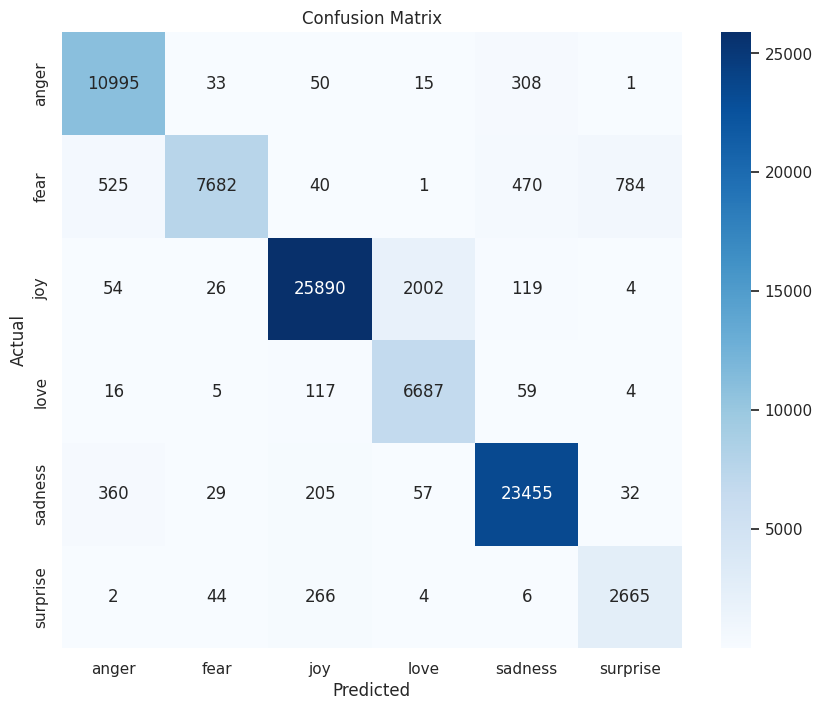

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_mapping.keys(),
            yticklabels=label_mapping.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

## Prediction and Inference

In [ ]:
def predict_emotion(text):
    # Tokenize the input text
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    )

    # Move inputs to the model's device
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).cpu().numpy()[0]

    # Map back to label
    emotion = label_encoder.inverse_transform([predicted_class])[0]
    return emotion

In [ ]:
sample_text = "I am so happy and excited about the new opportunities!"
predicted_emotion = predict_emotion(sample_text)
print(f"Text: {sample_text}\nPredicted Emotion: {predicted_emotion}")

Text: I am so happy and excited about the new opportunities!
Predicted Emotion: joy


## Save for future use

In [ ]:
# Save the model and tokenizer to a directory
output_dir = "/content/saved_model"

# Ensure the directory exists
import os
os.makedirs(output_dir, exist_ok=True)

# Save the model
trainer.save_model(output_dir)

# Save the tokenizer
tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")

Model and tokenizer saved to /content/saved_model
